In [1]:
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from skimage.transform import rescale, resize
from scipy.ndimage.filters import gaussian_filter
from scipy.io import loadmat
import imageio
from skimage import img_as_uint
import numpy as np
import math
import warnings
from img_measures import get_measures

In [7]:
## Read images, check all jpg images in path and read them.
## Return a list of images each with a matrix of height * width * 3(channels for colors).
def read_images(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('jpg')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.jpg';
        total_path = join(path,file);
        img = mpimg.imread(total_path);
        data.append(img);
    return onlyfiles, data;
def read_cluster_images(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('png')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.png';
        total_path = join(path,file);
        img = imageio.imread(total_path);
        data.append(img);
    return data;
def write_cluster_images(directory, imgs, names, k_param):
    i = 0;
    for k in k_param:
        sub_dir = join(directory, str(k));
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir);
        j = 0;
        for img in imgs[i]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                rimg = img_as_uint(img);
                imageio.imwrite(join(sub_dir, names[j] + '.png'), rimg);
            j += 1;
        i += 1;
## Read ground truth from mat files.
## Only care about segmented images, throw away boundary images.
## Return a list of a list of ground truth images.
def read_ground_truth(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('mat')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.mat';
        total_path = join(path,file);
        img = loadmat(total_path);
        process_img = [];
        for k in np.squeeze(img['groundTruth']).reshape(-1):
            process_img.append(k[0][0][0]);
            ## If we want boundary images with us.
            #for c in k[0][0]:
                #process_img.append(c);
        data.append(process_img);
    return data;
## Show image with its ground truths.
def show_img(real_data, gt_data, names, index):
    kn = 1 + len(gt_data[index]);
    n = int(math.sqrt(kn));
    mn = n;
    if (mn * n < kn):
        mn = mn + 1;
        if (mn * n < kn):
            n = n + 1;
    fig, ax = plt.subplots(n, mn, figsize=(20,20));
    fig.suptitle('Image ' + names[index], fontsize=20)
    ax[0][0].imshow(real_data[index]);
    for i in range(len(gt_data[index])):
        rem = (i + 1) % mn;
        k = int((i + 1) / mn);
        ax[k, rem].imshow(gt_data[index][i]);
    plt.show();
def show_single_img(img):
    plt.imshow(img);
    plt.show();
def show_cluster_img(real_data, kimgs, names, index, k_params):
    kn = 1 + len(kimgs);
    n = int(math.sqrt(kn));
    mn = n;
    if (mn * n < kn):
        mn = mn + 1;
        if (mn * n < kn):
            n = n + 1;
    fig, ax = plt.subplots(n, mn, figsize=(20,20));
    fig.suptitle('Image ' + names[index], fontsize=20)
    ax[0][0].imshow(real_data[index]);
    for i in range(len(kimgs)):
        rem = (i + 1) % mn;
        k = int((i + 1) / mn);
        ax[k, rem].set_title('K = ' + str(k_params[i]));
        ax[k, rem].imshow(kimgs[i][index]);
    plt.show();
def resize_real_img(real_data, reduce_to, apply_gauss = False, sigma = 2):
    resize_data = [];
    for img in real_data:
        gres_img = img.copy();
        res_img = np.zeros( (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to), 3));
        if (apply_gauss):
            gres_img[:,:,0] = gaussian_filter(img[:,:,0], sigma=sigma);
            gres_img[:,:,1] = gaussian_filter(img[:,:,1], sigma=sigma);
            gres_img[:,:,2] = gaussian_filter(img[:,:,2], sigma=sigma);
        res_img[:,:,0] = resize(gres_img[:,:,0], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        res_img[:,:,1] = resize(gres_img[:,:,1], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        res_img[:,:,2] = resize(gres_img[:,:,2], (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
        resize_data.append(res_img);
    return resize_data;
def resize_gt_img(ground_truth, reduce_to, apply_gauss = False, sigma = 2):
    resize_data = [];
    for gt in ground_truth:
        res_data_min = [];
        for img in gt:
            gimg = img;
            if (apply_gauss):
                gimg = gaussian_filter(img, sigma=sigma)
            res_img = resize(gimg, (int(img.shape[0] * reduce_to), int(img.shape[1] * reduce_to)),  mode='constant');
            res_data_min.append(res_img);
        resize_data.append(res_data_min);
    return resize_data;
def get_scores(gts, cds, k_param):
    tf = [];
    tc = [];
    taf = [];
    tac = [];
    for k in range(len(k_param)):
        i = 0;
        f_meas = [];
        cond_entr = [];
        average_f = [];
        average_c_ent = [];
        for img in cds[k]:
            min_f = [];
            min_cent = [];
            for gt in gts[i]:
                fimg = img.reshape(-1);
                fgt = gt.reshape(-1);
                f, c = get_measures(fgt, fimg);
                min_f.append(f);
                min_cent.append(c);
            f_meas.append(min_f);
            cond_entr.append(min_cent);
            average_f.append(np.mean(min_f));
            average_c_ent.append(np.mean(min_cent));
            i += 1;
        tf.append(f_meas);
        tc.append(cond_entr);
        taf.append(average_f);
        tac.append(average_c_ent);
    return tf, tc, taf, tac;

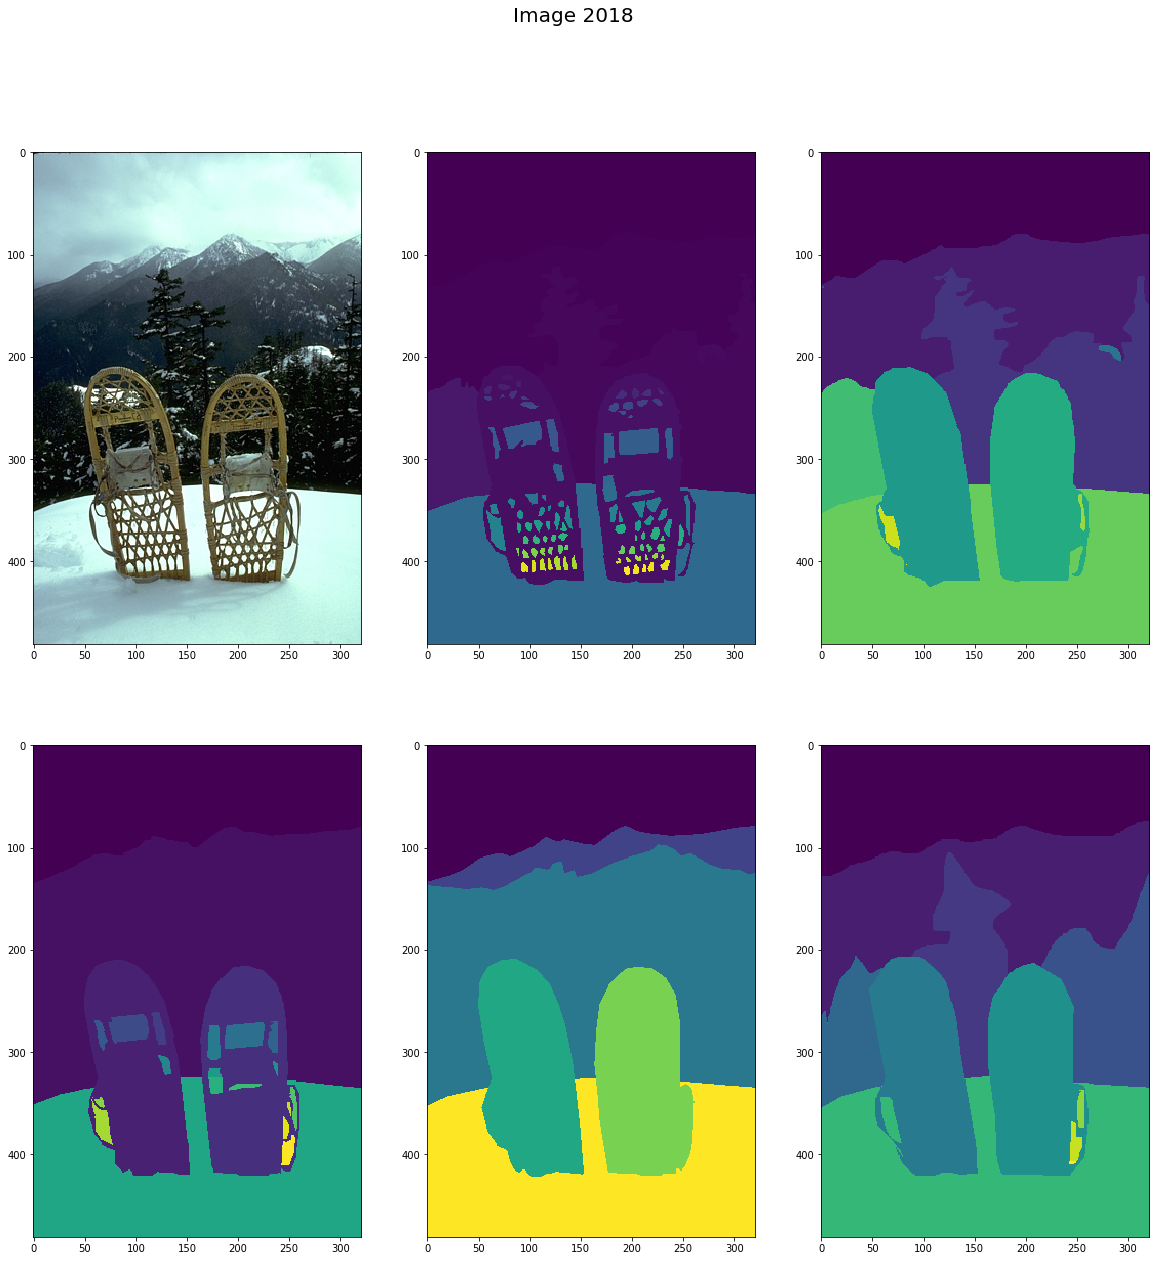

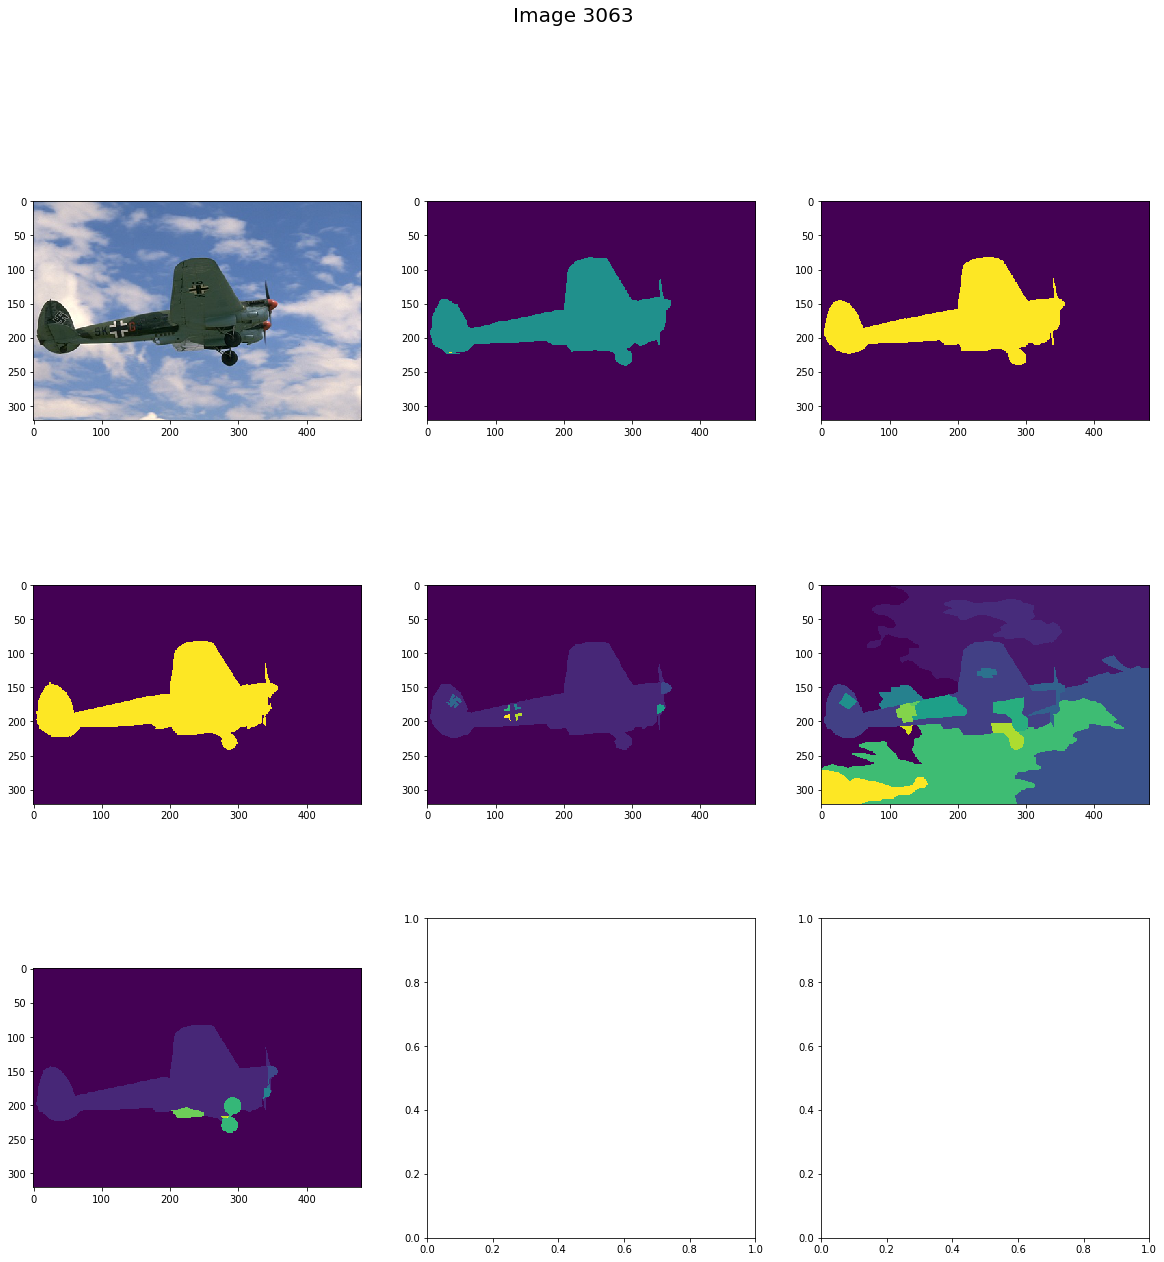

In [8]:
names, real_data = read_images('data/images/test');
real_gt = read_ground_truth('data/groundTruth/test');
show_img(real_data, real_gt, names, 0);
show_img(real_data, real_gt, names, 1);

In [9]:
## K-Means with different k
do_kmeans_run = False;
if do_kmeans_run:
    k_param = [3,5,7,9,11];
    k_results = [];
    for k in k_param:
        min_k = [];
        i = 0;
        print('Starting with k : ', k);
        for img in real_data:
            img_u = img.reshape(-1, 3);
            kmeans = KMeans(n_clusters=k, random_state=0).fit(img_u);
            min_k.append(kmeans.labels_.reshape(img.shape[:-1]));
            i = i + 1;
            if (i % 20 == 0):
                print('Finished : ', i / 2, '%')
        k_results.append(min_k);
else:
    print('Generation bypassed, will be read from stored results...');

Generation bypassed, will be read from stored results...


In [10]:
if do_kmeans_run:
    directory = 'results/kmeans'
    k_param = [3,5,7,9,11];
    write_cluster_images(directory, k_results, names, k_param);
    print('All results saved...');
else:
    print('No results to save, skip to reading');

No results to save, skip to reading


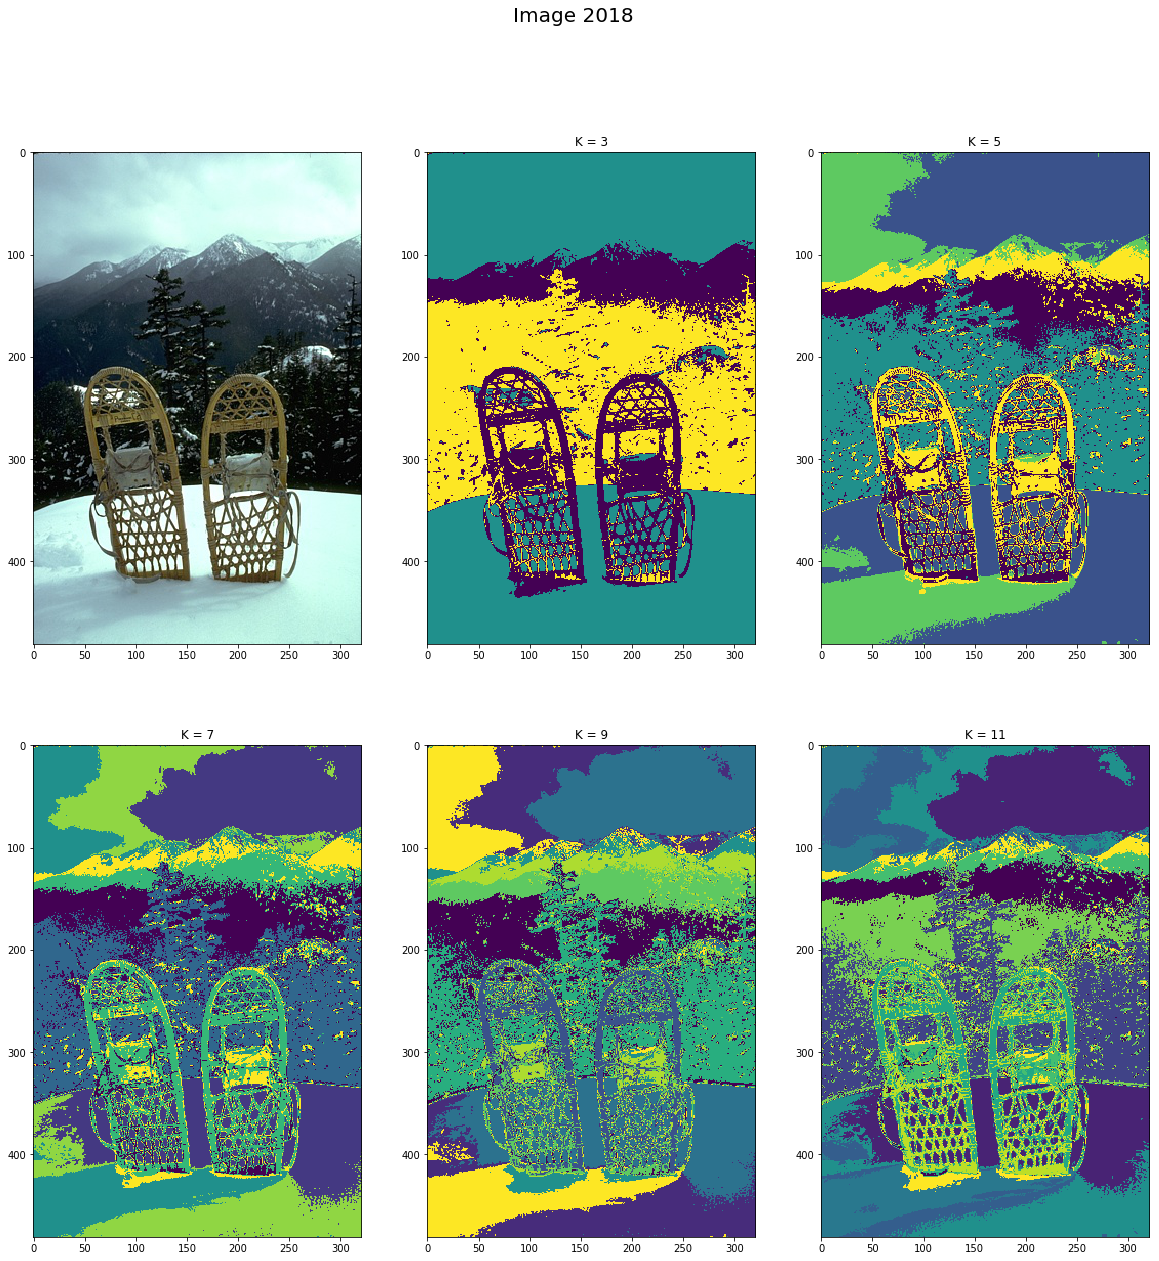

In [12]:
directory = 'results/kmeans'
k_param = [3,5,7,9,11];
k_results = [];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    k_results.append(lk);
show_cluster_img(real_data, k_results, names, 0, k_param);

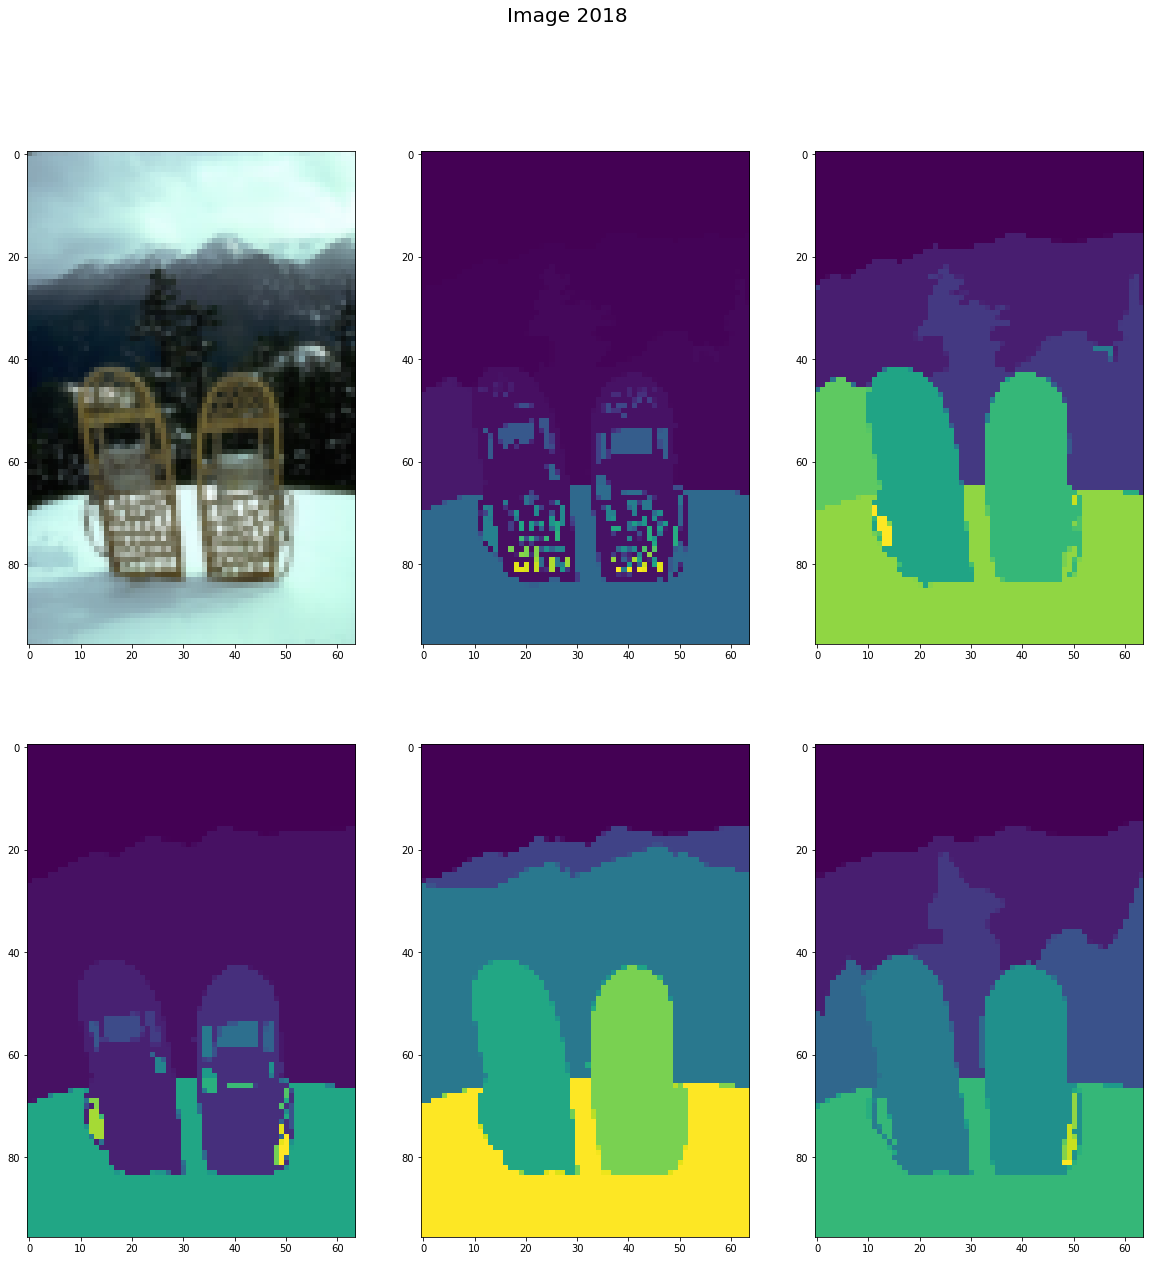

In [13]:
resize_to = 0.2;
mod_data = resize_real_img(real_data, resize_to, True);
mod_gt = resize_gt_img(real_gt, resize_to);
show_img(mod_data, mod_gt, names, 0);

In [14]:
## Spectral clustering with different k
do_spectral_clustering = False;
k_param = [3,5,7,9,11];
s_results = [[[] for i in range(len(k_param))] for j in range(3)];
if do_spectral_clustering:
    index = 0;
    for img in mod_data:
        i = 0;
        img_u = img.reshape(-1, 3);
        ## Following https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
        ## RBF kernel -> np.exp(-gamma * d(X,X) ** 2) where d(X,X) is ecludiean distance.
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='rbf', gamma = 1);
        rbf_1_aff = spectCluster.fit(img_u).affinity_matrix_;
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='rbf', gamma = 10);
        rbf_10_aff = spectCluster.fit(img_u).affinity_matrix_;
        spectCluster = SpectralClustering(n_clusters=11, random_state=0, affinity='nearest_neighbors', n_neighbors = 5);
        nn_5_aff = spectCluster.fit(img_u).affinity_matrix_;
        for k in k_param:
            spectCluster = SpectralClustering(n_clusters=k, random_state=0, affinity='precomputed');
            clustering = spectCluster.fit(rbf_1_aff);
            s_results[0][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            clustering = spectCluster.fit(rbf_10_aff);
            s_results[1][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            clustering = spectCluster.fit(nn_5_aff);
            s_results[2][i].append(clustering.labels_.reshape(img.shape[:-1]).copy());
            i = i + 1;
        index += 1;
        if (index % 20 == 0):
            print('Finished : ', index / 2, '%');
else:
    print('Generation bypassed, will be read from stored results...');

Generation bypassed, will be read from stored results...


In [15]:
if do_spectral_clustering:
    k_param = [3,5,7,9,11];
    directory = 'results/spectral/rbf_1';
    write_cluster_images(directory, s_results[0], names, k_param);
    directory = 'results/spectral/rbf_10'
    write_cluster_images(directory, s_results[1], names, k_param);
    directory = 'results/spectral/nn_5'
    write_cluster_images(directory, s_results[2], names, k_param);
    print('All results saved...');
else:
    print('No results to save, skip to reading');

No results to save, skip to reading


RBF with gamma = 1


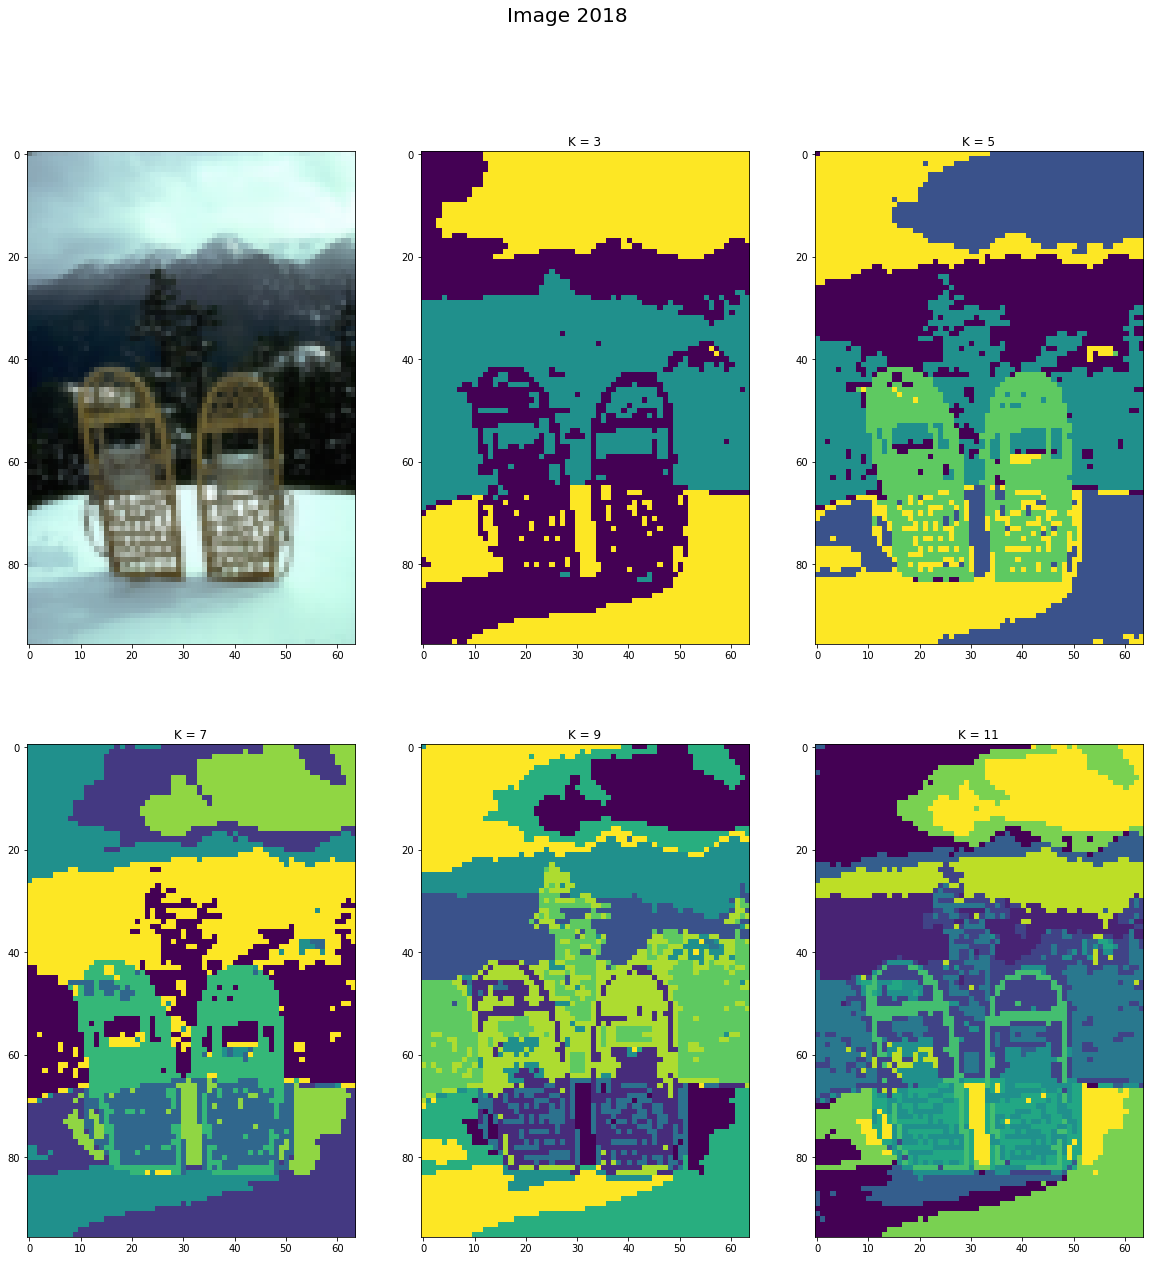

RBF with gamma = 10


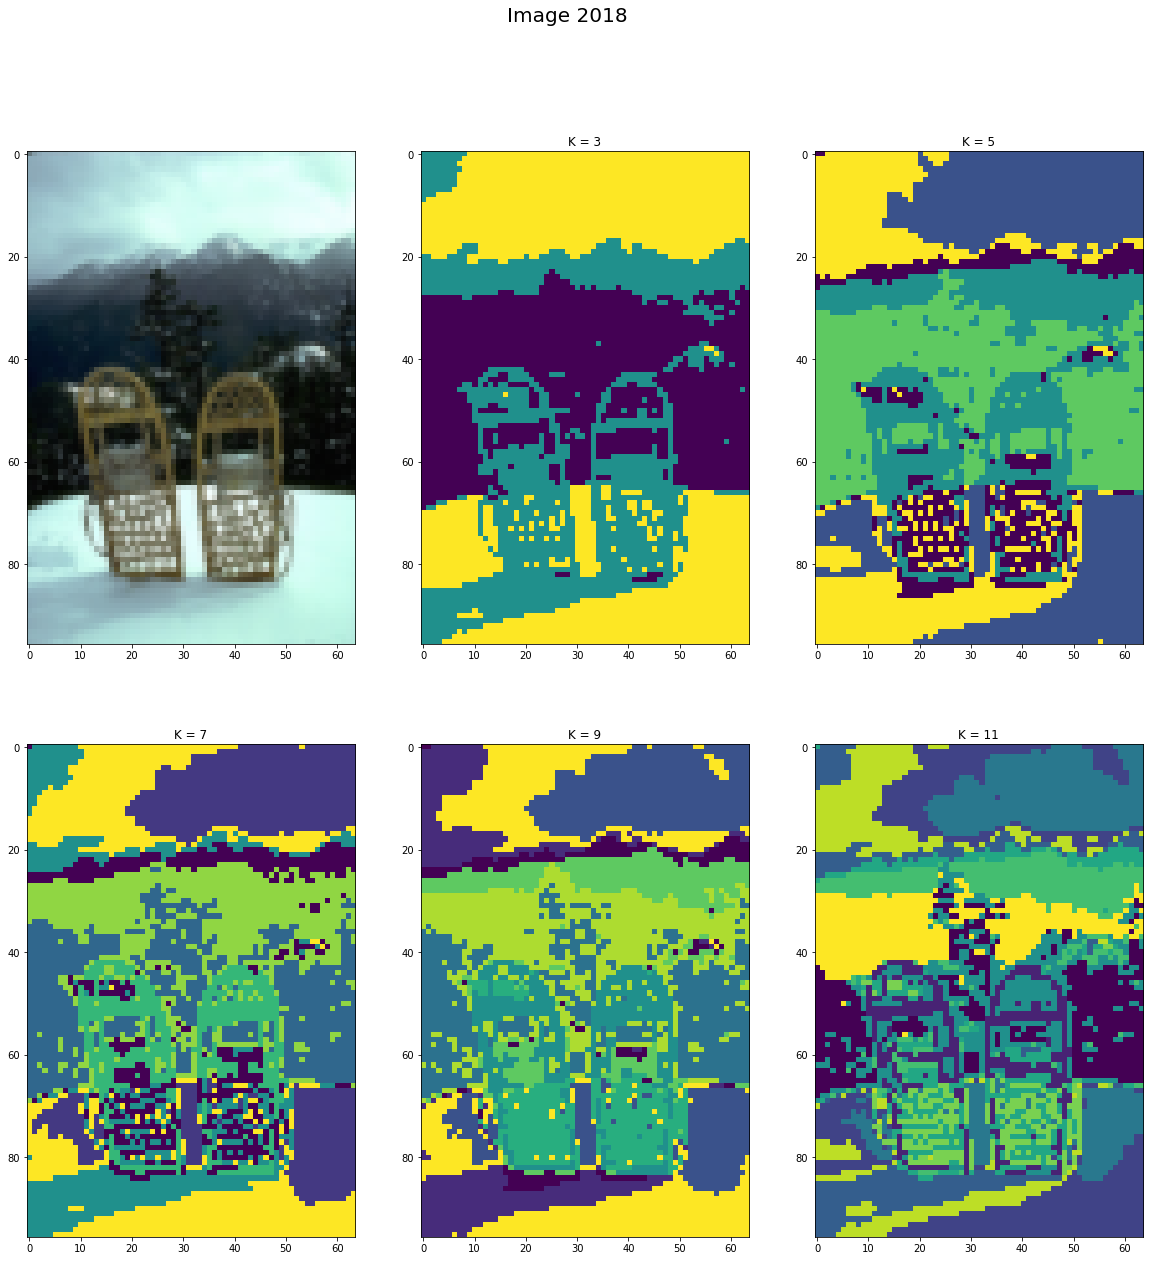

Nearest Neighbours with n = 5


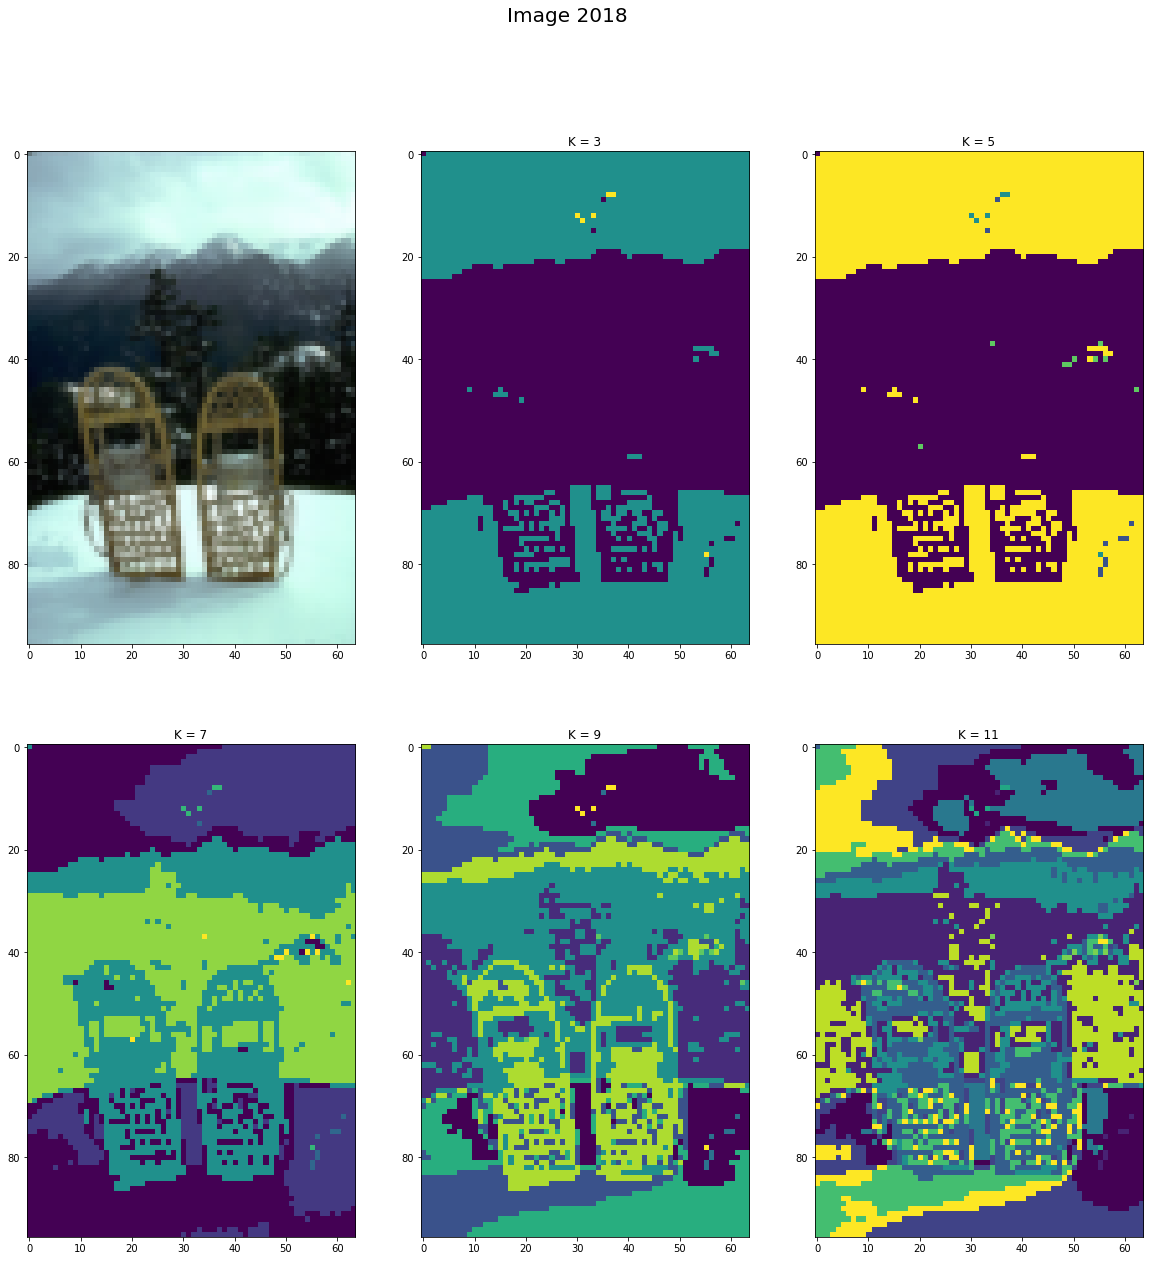

In [16]:
directory = 'results/spectral/rbf_1'
k_param = [3,5,7,9,11];
s_results = [[] for j in range(3)];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[0].append(lk);
directory = 'results/spectral/rbf_10'
k_param = [3,5,7,9,11];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[1].append(lk);
directory = 'results/spectral/nn_5'
k_param = [3,5,7,9,11];
for k in k_param:
    sub_dir = join(directory, str(k));
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir);
    lk = read_cluster_images(sub_dir);
    s_results[2].append(lk);
print('RBF with gamma = 1');
show_cluster_img(mod_data, s_results[0], names, 0, k_param);
print('RBF with gamma = 10');
show_cluster_img(mod_data, s_results[1], names, 0, k_param);
print('Nearest Neighbours with n = 5');
show_cluster_img(mod_data, s_results[2], names, 0, k_param);

In [17]:
print('Calculating kmeans scores...');
k_f, k_c, k_af, k_ac = get_scores(real_gt, k_results, k_param);
print('Done');
print('Calculating RBF-1 scores...');
rbf1_f, rbf1_c, rbf1_af, rbf1_ac = get_scores(mod_gt, s_results[0], k_param);
print('Done');
print('Calculating RBF-10 scores...');
rbf10_f, rbf10_c, rbf10_af, rbf10_ac = get_scores(mod_gt, s_results[1], k_param);
print('Done');
print('Calculating NN-5 scores...');
nn5_f, nn5_c, nn5_af, nn5_ac = get_scores(mod_gt, s_results[2], k_param);
print('Done');

Calculating kmeans scores...
Done
Calculating RBF-1 scores...
Done
Calculating RBF-10 scores...
Done
Calculating NN-5 scores...
Done


In [36]:
def print_stats(method_name, af, ac, k_param):
    print(method_name + " : ");
    for i in range(len(af)):
        plt.figure(figsize=(20,10));
        plt.title(method_name + ' with k = ' + str(k_param[i]));
        plt.plot(af[i], label = 'Average F-measure');
        plt.plot(ac[i], label = 'Average Conditional Entropy');
        plt.legend();
        plt.show();
        print('With k = ' , k_param[i]);
        print('Average F-measure over dataset : ', np.mean(af[i]));
        print('Average Conditional entropy over dataset : ', np.mean(ac[i]));

K-means : 


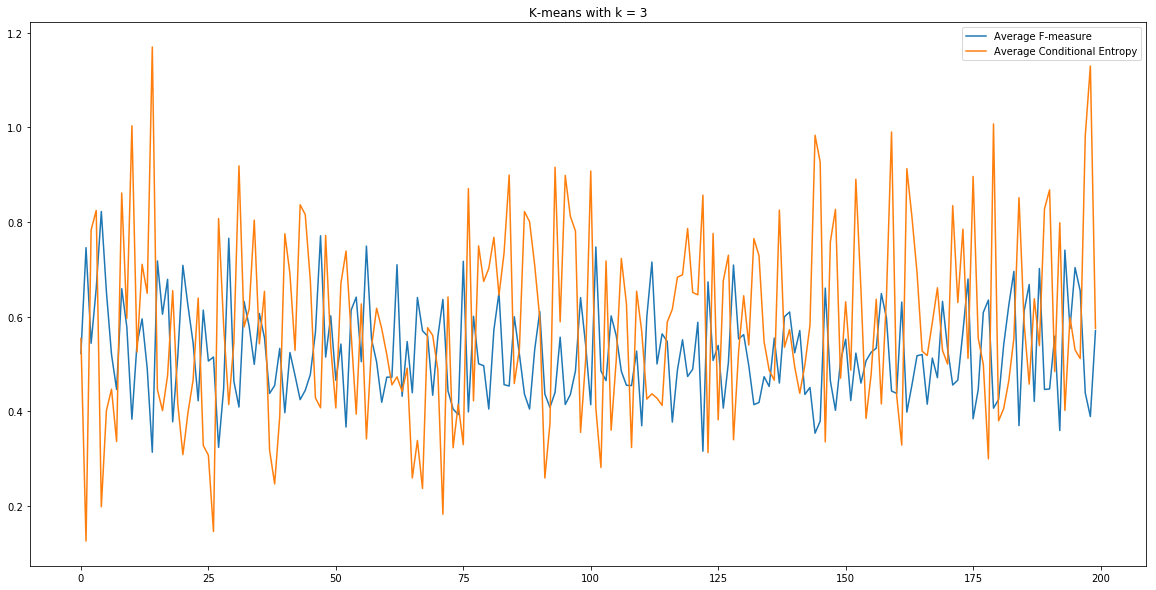

With k =  3
Average F-measure over dataset :  0.5238836219172895
Average Conditional entropy over dataset :  0.5846179479157467


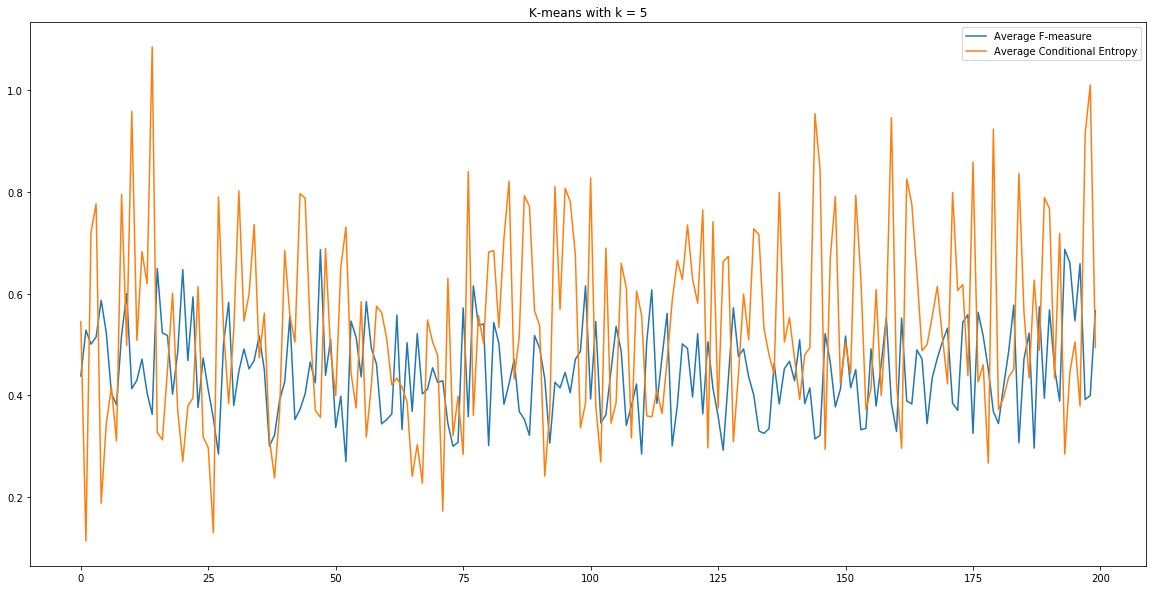

With k =  5
Average F-measure over dataset :  0.4459619913805923
Average Conditional entropy over dataset :  0.5352544856747694


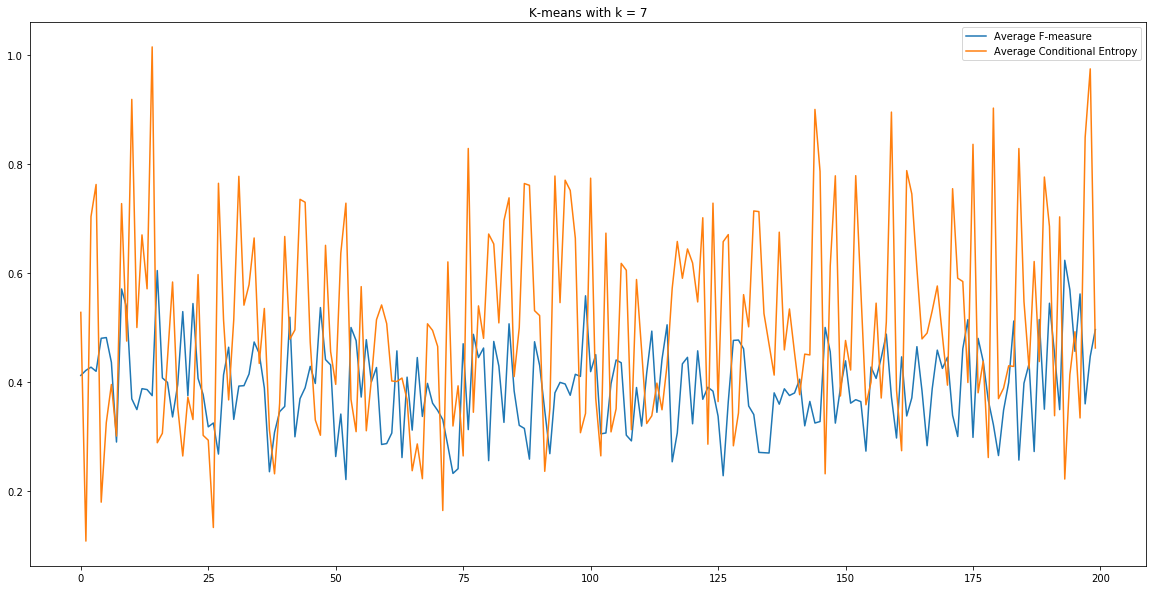

With k =  7
Average F-measure over dataset :  0.3907162574108324
Average Conditional entropy over dataset :  0.5080840188942836


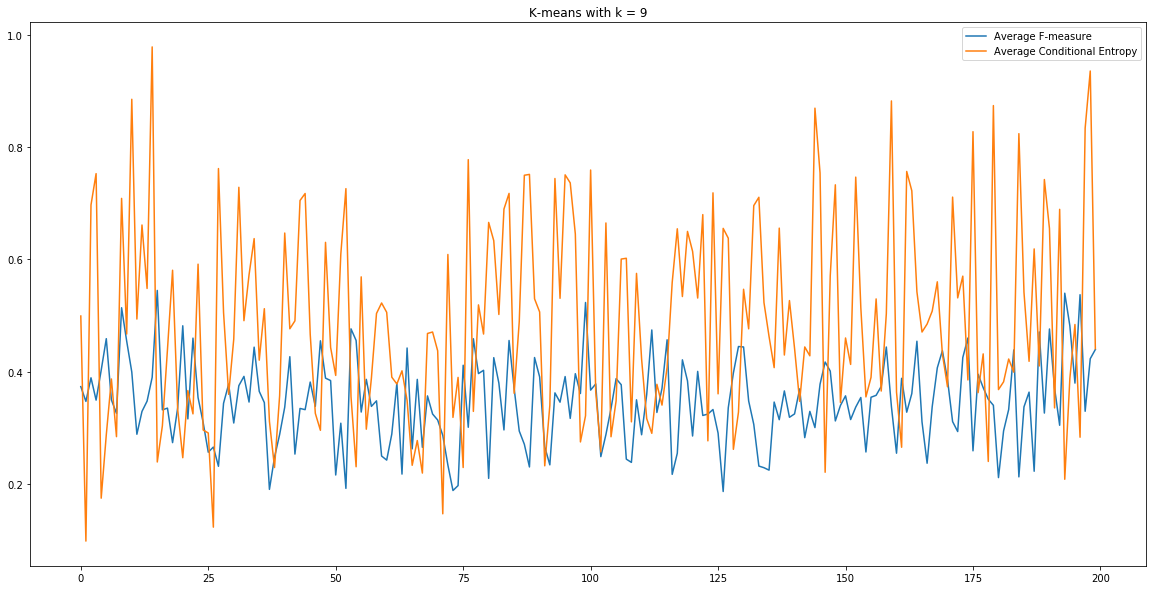

With k =  9
Average F-measure over dataset :  0.3460146016063521
Average Conditional entropy over dataset :  0.49090014653477226


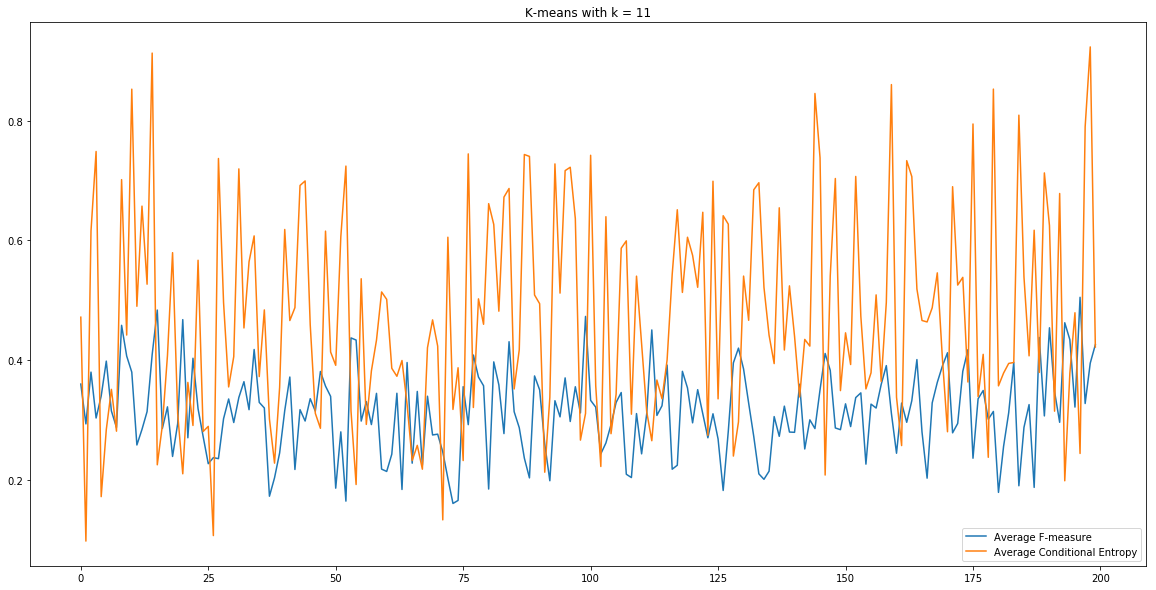

With k =  11
Average F-measure over dataset :  0.31417965944297177
Average Conditional entropy over dataset :  0.474304837715364


In [37]:
print_stats('K-means', k_af, k_ac, k_param);

RBF-1 : 


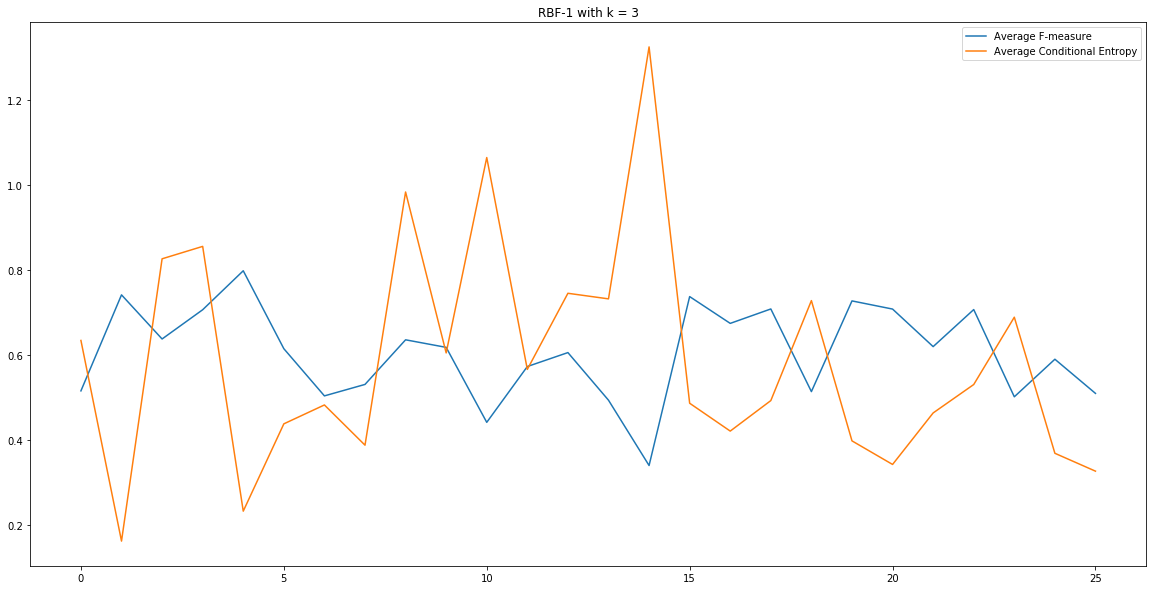

With k =  3
Average F-measure over dataset :  0.6059579636571031
Average Conditional entropy over dataset :  0.58802146736598


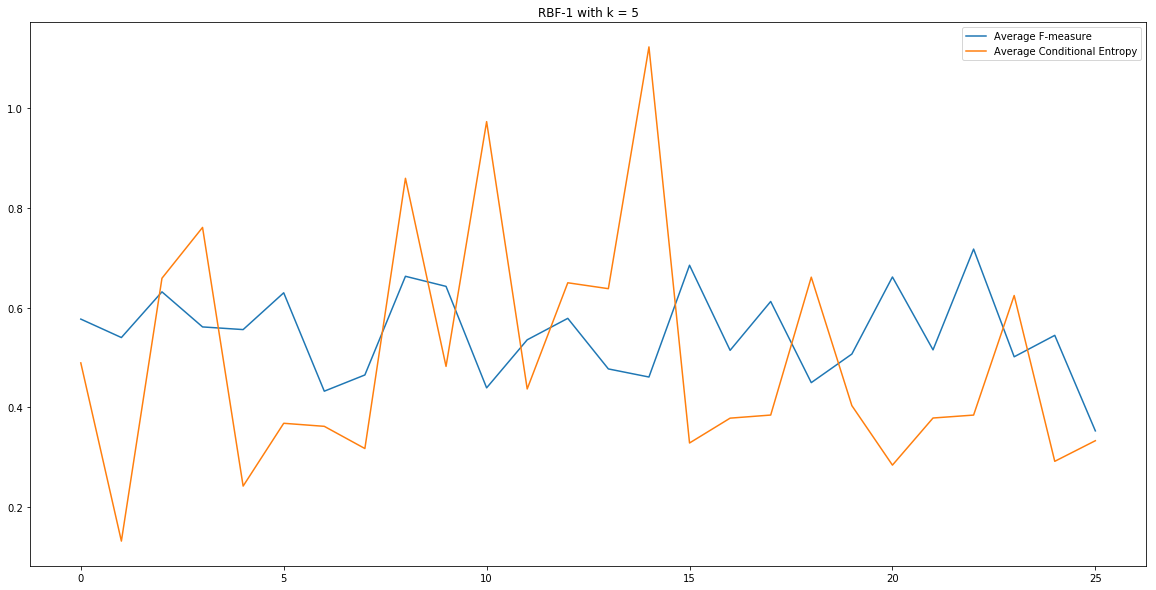

With k =  5
Average F-measure over dataset :  0.5483518328330299
Average Conditional entropy over dataset :  0.4981033391695382


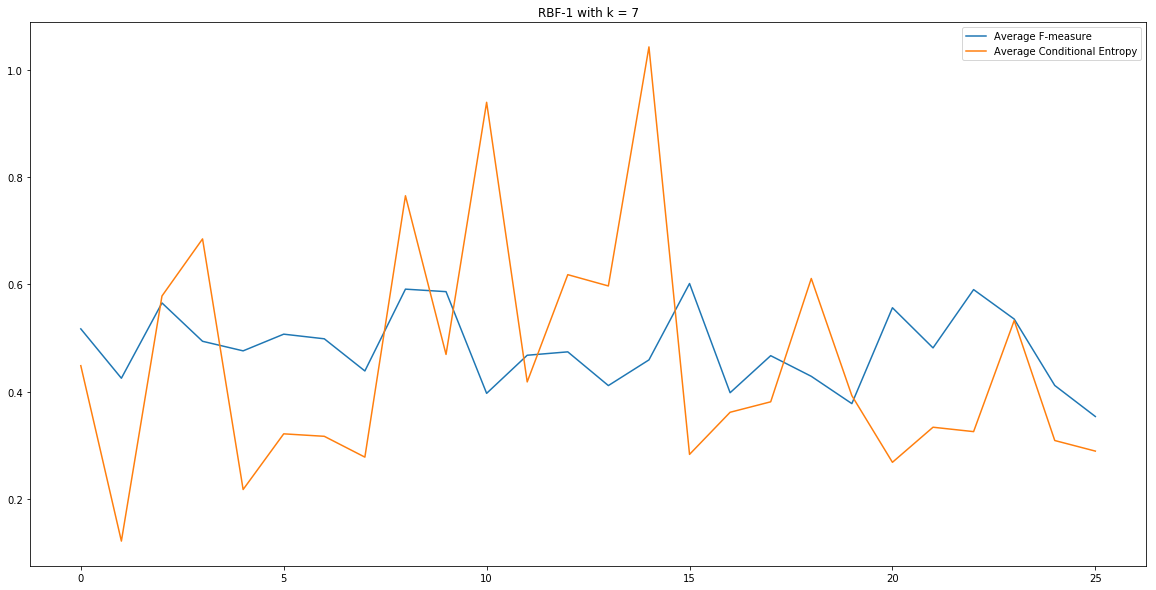

With k =  7
Average F-measure over dataset :  0.4812217194727152
Average Conditional entropy over dataset :  0.4578924303607667


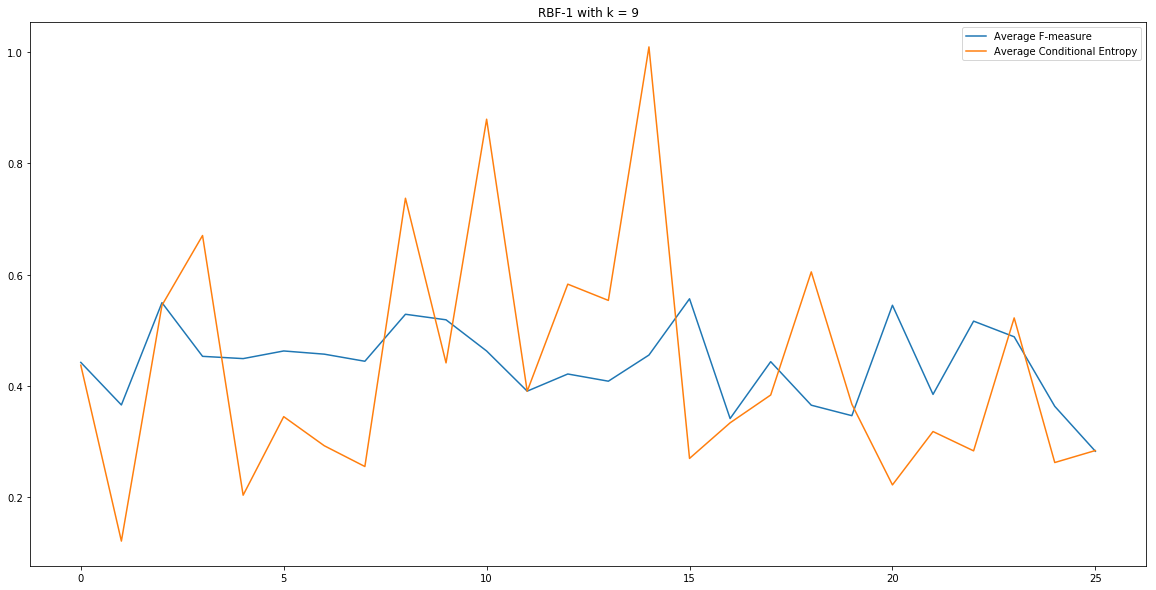

With k =  9
Average F-measure over dataset :  0.44006100653811153
Average Conditional entropy over dataset :  0.43507555941836973


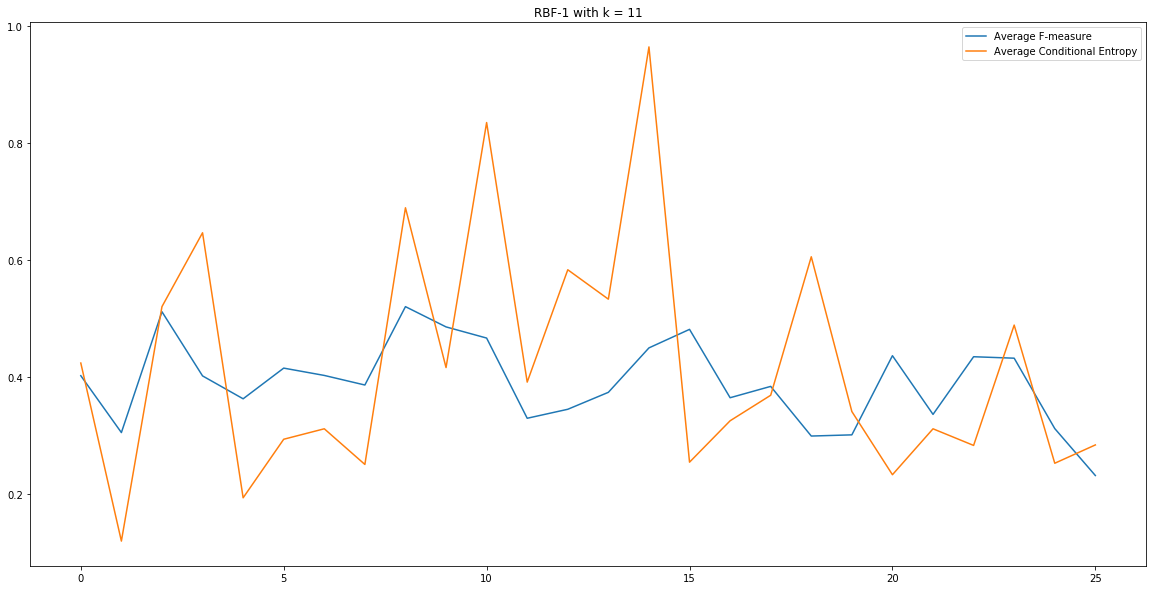

With k =  11
Average F-measure over dataset :  0.3909404356426273
Average Conditional entropy over dataset :  0.4197236922357384


In [38]:
print_stats('RBF-1', rbf1_af, rbf1_ac, k_param)

RBF-10 : 


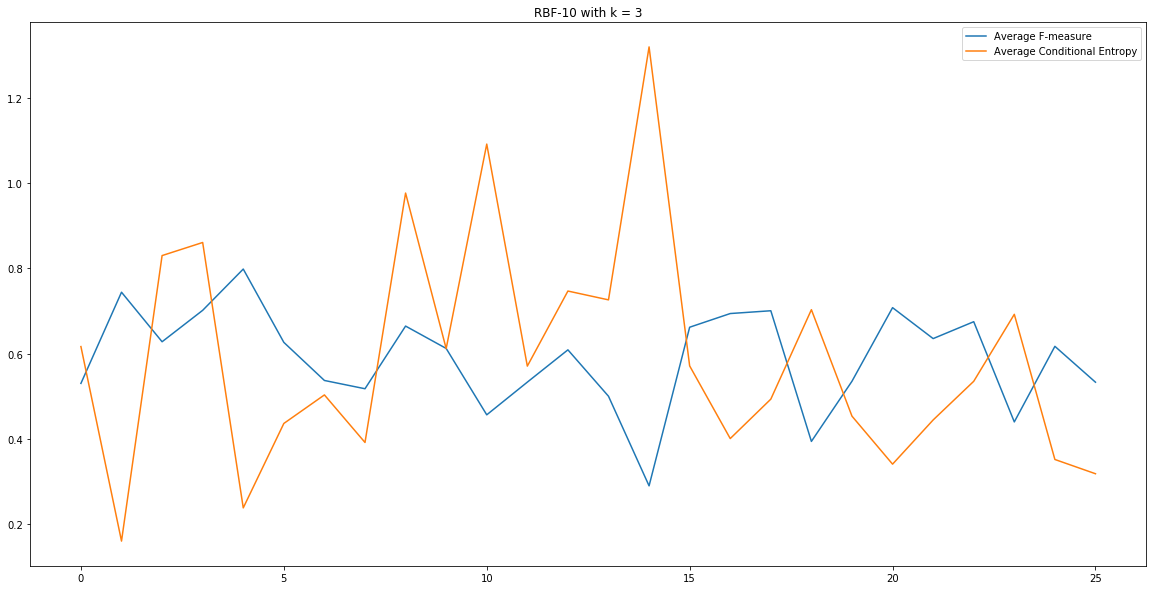

With k =  3
Average F-measure over dataset :  0.5903317602319089
Average Conditional entropy over dataset :  0.5919304051661961


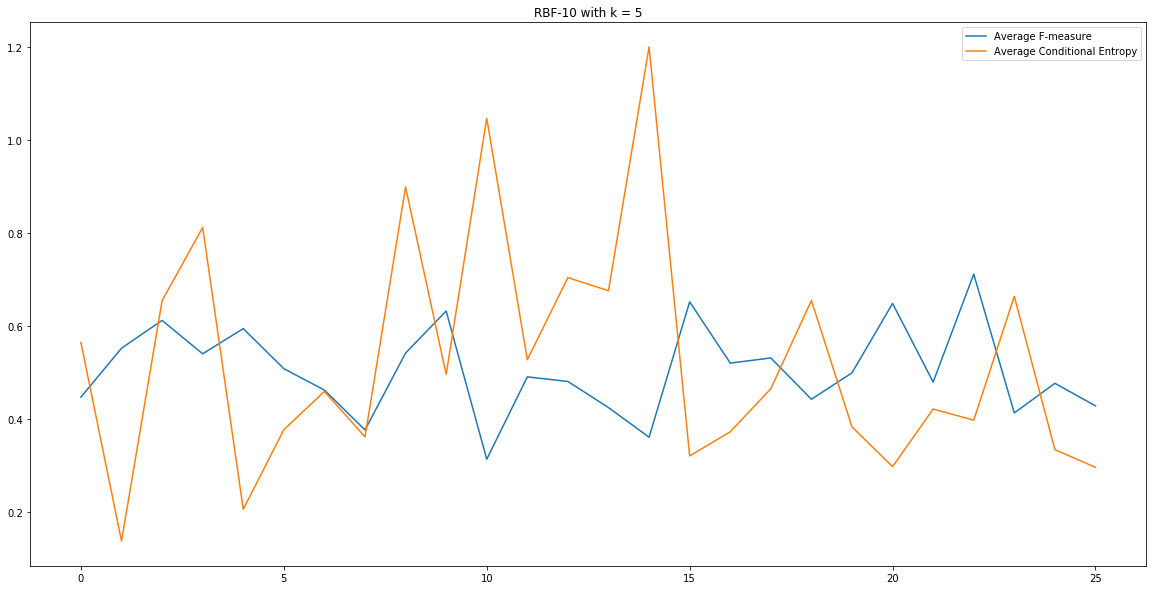

With k =  5
Average F-measure over dataset :  0.5049686447375181
Average Conditional entropy over dataset :  0.5276177998053576


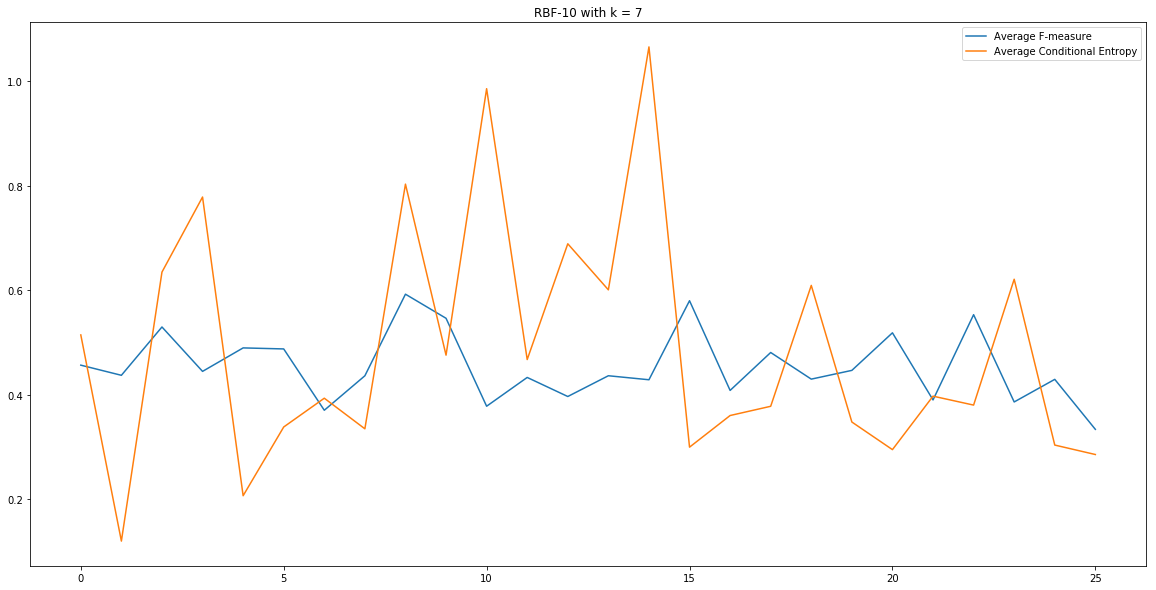

With k =  7
Average F-measure over dataset :  0.4544768975438173
Average Conditional entropy over dataset :  0.4877386754157436


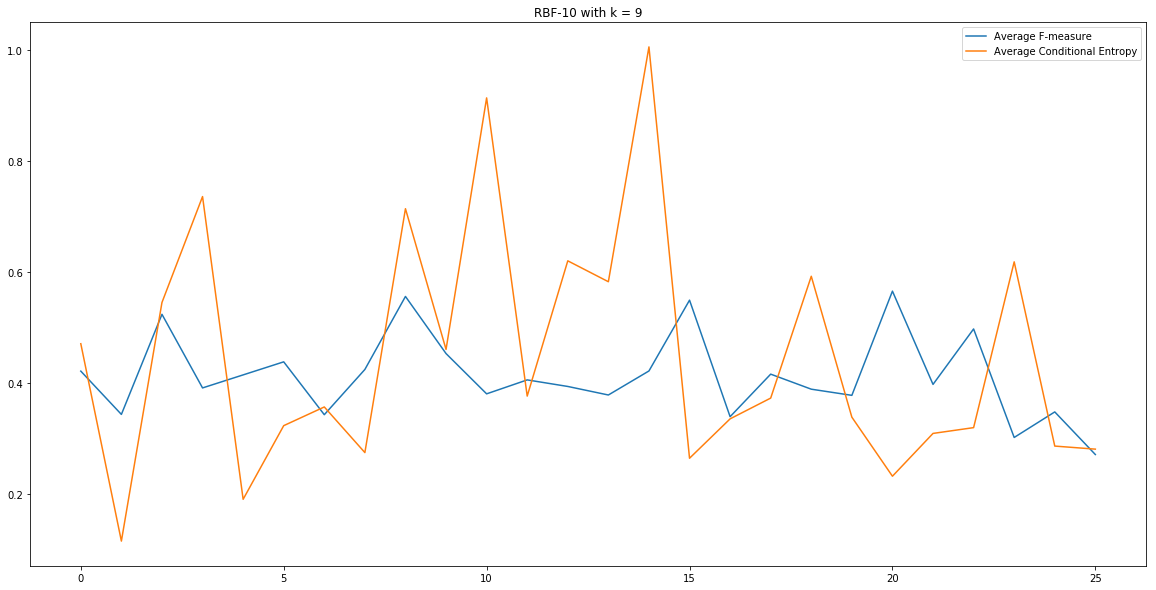

With k =  9
Average F-measure over dataset :  0.4136457905972207
Average Conditional entropy over dataset :  0.4480288317306474


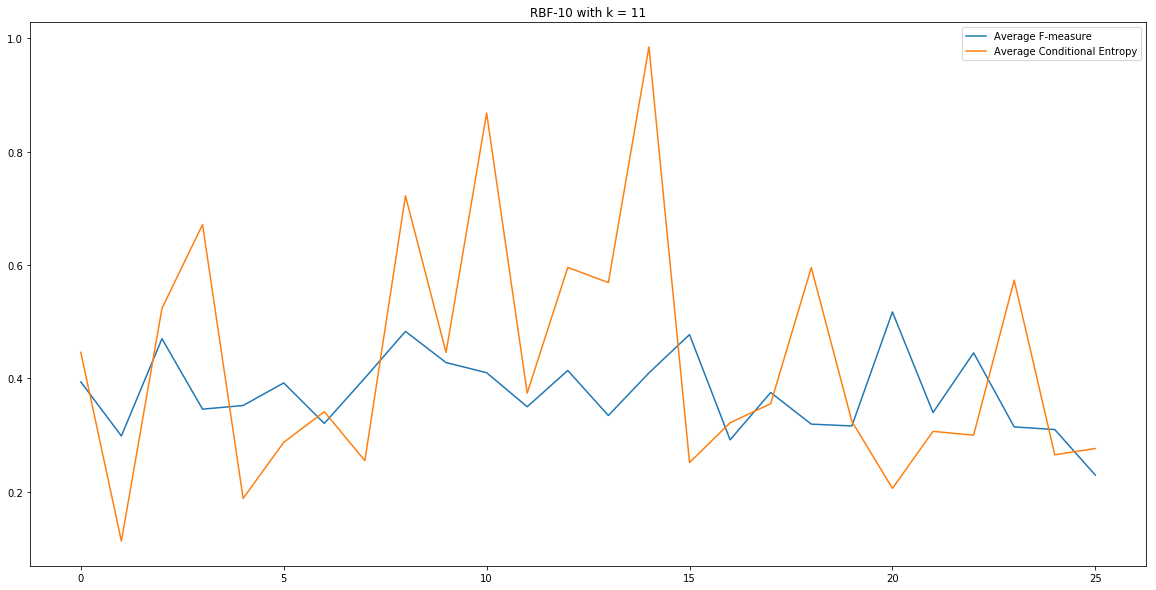

With k =  11
Average F-measure over dataset :  0.37442452792753195
Average Conditional entropy over dataset :  0.42917414859917274


In [39]:
print_stats('RBF-10', rbf10_af, rbf10_ac, k_param);

Nearset Neighbours 5 : 


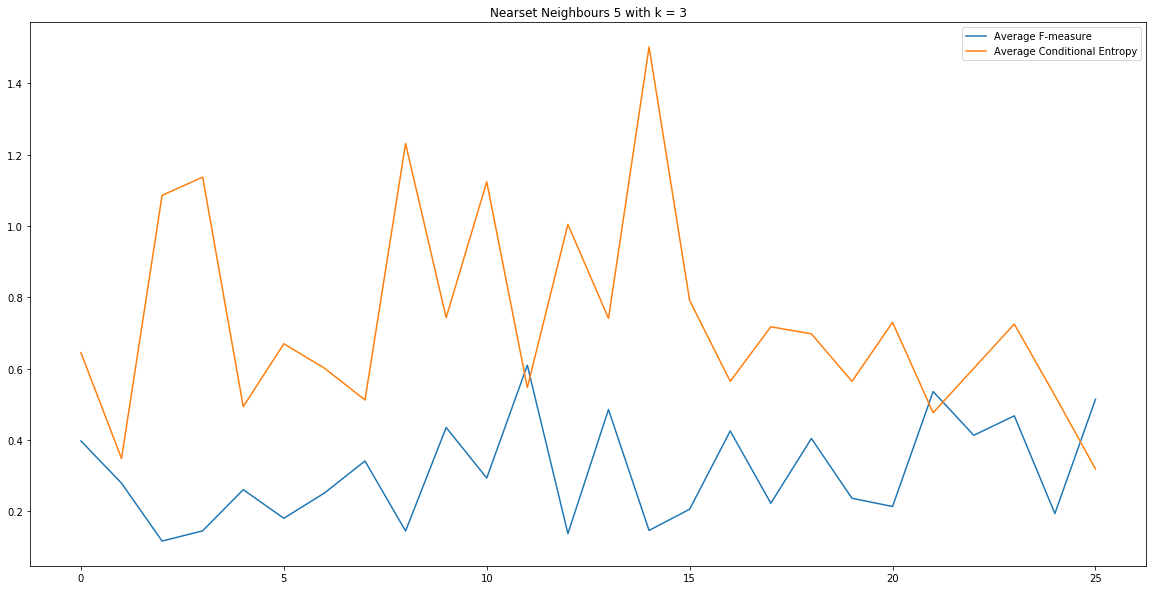

With k =  3
Average F-measure over dataset :  0.3101765227304779
Average Conditional entropy over dataset :  0.7345149219420334


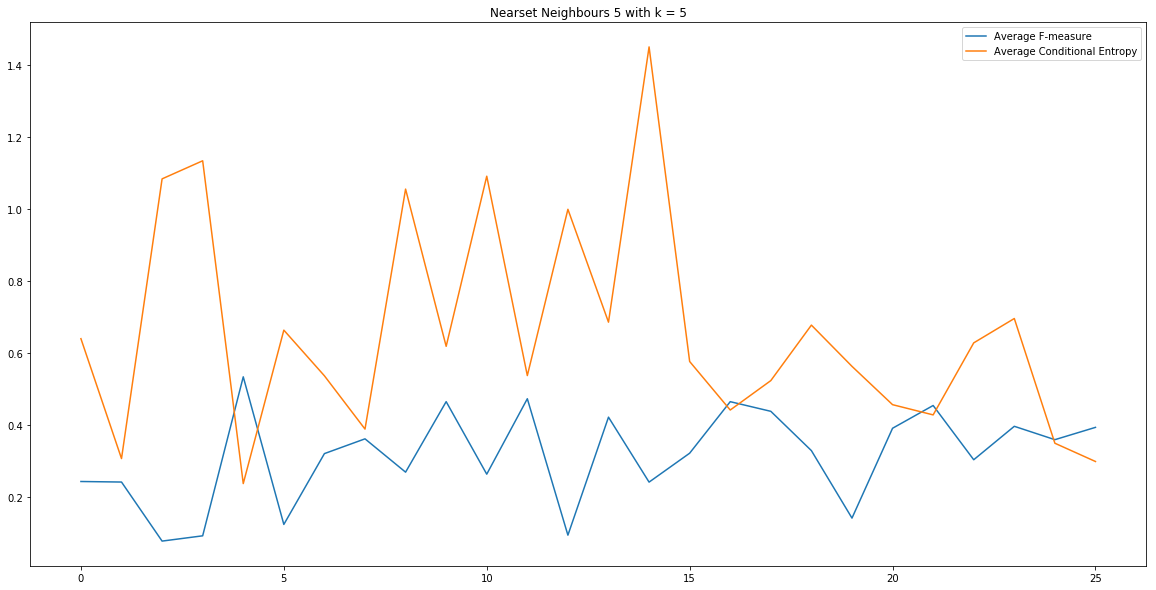

With k =  5
Average F-measure over dataset :  0.31694122576799094
Average Conditional entropy over dataset :  0.6575000859593177


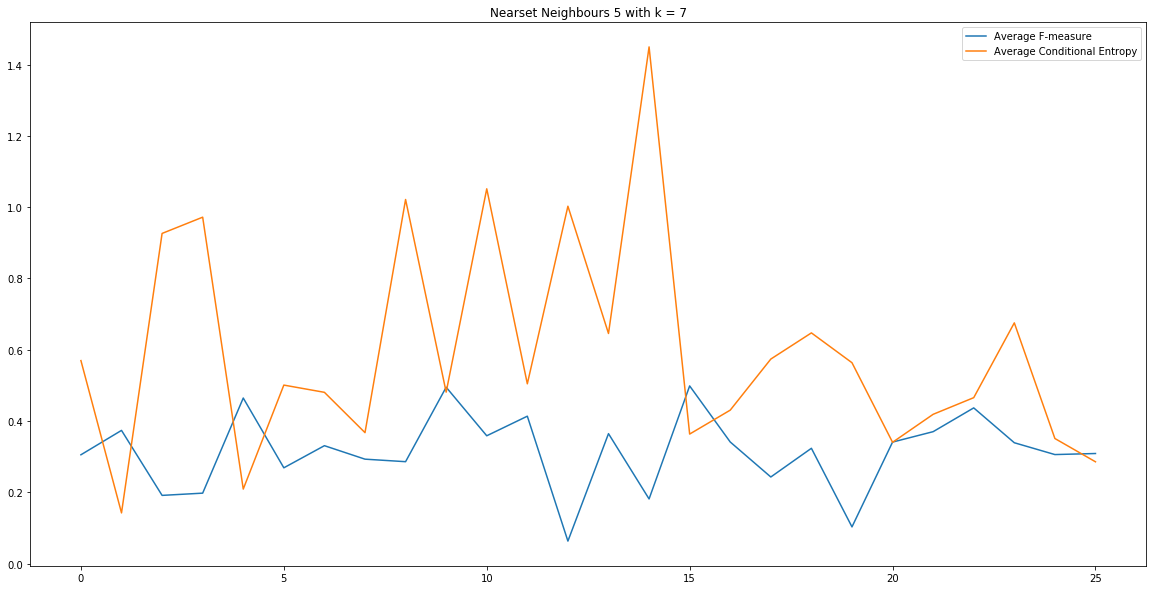

With k =  7
Average F-measure over dataset :  0.31527999767116033
Average Conditional entropy over dataset :  0.593782871693529


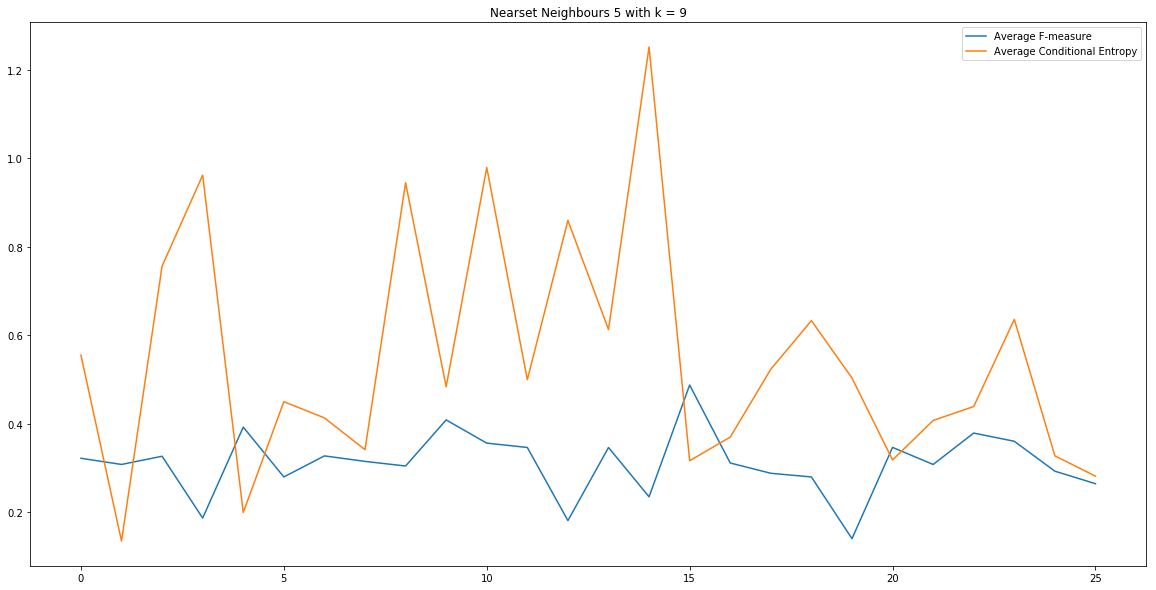

With k =  9
Average F-measure over dataset :  0.310917323003225
Average Conditional entropy over dataset :  0.5457639735913975


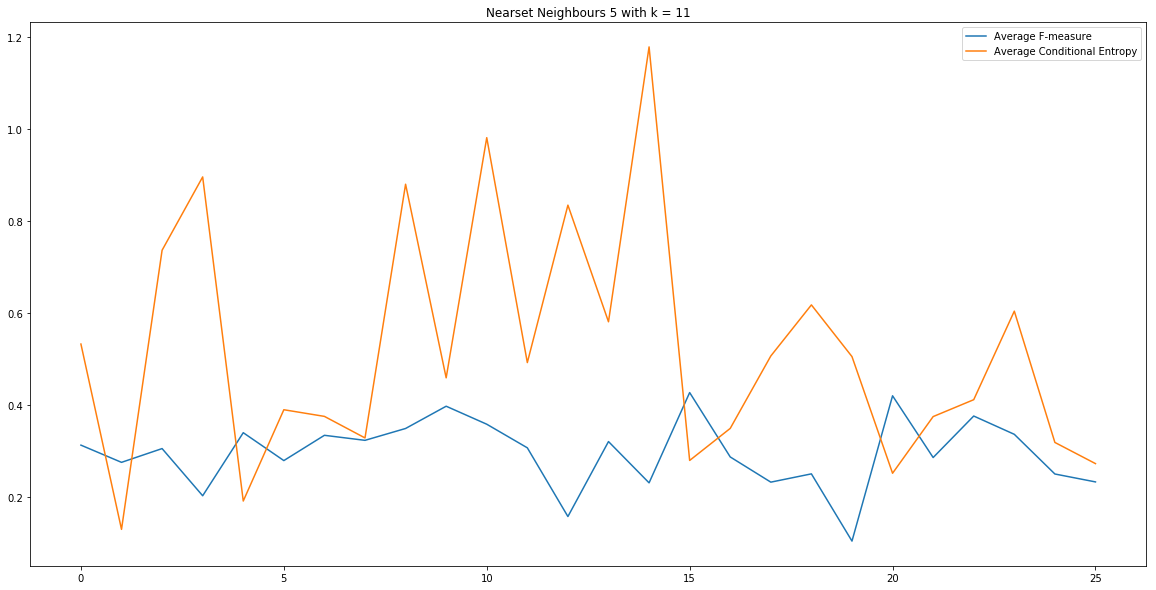

With k =  11
Average F-measure over dataset :  0.29602502049867235
Average Conditional entropy over dataset :  0.5186108532842391


In [40]:
print_stats('Nearset Neighbours 5', nn5_af, nn5_ac, k_param);